In [2]:
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import History, EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Knowledge-Distillation")
os.listdir()

['MNIST_KD.ipynb',
 'models',
 'plot_utils',
 'actions',
 'CIFAR10_ResNet18.h5',
 'CIFAR10_Student_Model.h5',
 'alpha_temp.npy',
 'amount_data.npy',
 'CIFAR-10.ipynb',
 'TA_KD_Save',
 'TA-KD.ipynb']

In [5]:
import plot_utils.Plot_Heatmap
import plot_utils.Plot_Model
import actions.Classification_Distiller as Distiller

In [6]:
def loadDataset():
  (trainX, trainy), (testX, testy) = cifar10.load_data()

  trainy = trainy
  testy  = testy
  
  train_norm = trainX.astype('float32')/255.0
  test_norm  = testX.astype('float32')/255.0

  return train_norm, trainy, test_norm, testy

In [7]:
trainX, trainy, testX, testy = loadDataset()

170500096/170498071 [==============================] - 4s 0us/step


In [8]:
def saveModel(inp_model, filename):
  inp_model.save(filename)
  return

def loadModel(filename):
  model = load_model(filename)
  return model

## Building CNN models with 2, 4, 6, 8, 10 convolutional layers.

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def createStudentModel(name = "Student-Model", conv_layers=4, teacher=True):
    assert conv_layers == 2 or conv_layers == 4 or conv_layers == 6 or conv_layers == 8 or conv_layers == 10

    model = Sequential(name=name + "-" + str(conv_layers) + "_layers")

    if conv_layers == 2:
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Flatten())
      model.add(Dropout(0.4))
      model.add(Dense(10, activity_regularizer=l2(1e-4)))   # activation = None is important, as we will use logits for calculating softened probabilities

      return model

    if conv_layers == 4:
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
      model.add(BatchNormalization())
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Flatten())
      model.add(Dropout(0.4))
      model.add(Dense(10, activity_regularizer=l2(1e-4)))   # activation = None is important, as we will use logits for calculating softened probabilities

      return model

    if conv_layers == 6:
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
      model.add(BatchNormalization())
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(0.4))

      model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))

      model.add(Flatten())
      model.add(Dropout(0.4))
      model.add(Dense(10, activity_regularizer=l2(1e-4)))   # activation = None is important, as we will use logits for calculating softened probabilities

      return model

    if conv_layers == 8:
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
      model.add(BatchNormalization())
      model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(0.4))

      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(0.4))

      model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(0.4))

      model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D((2, 2)))
      model.add(Dropout(0.4))

      model.add(Flatten())
      model.add(Dense(64, activation="relu", activity_regularizer=l2(1e-4)))
      model.add(Dense(10, activity_regularizer=l2(1e-4)))   # activation = None is important, as we will use logits for calculating softened probabilities

      return model

    # if conv_layers == 10:
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", activity_regularizer=l2(1e-4)))
    model.add(Dropout(0.4))
    model.add(Dense(10, activity_regularizer=l2(1e-4)))   # activation = None is important, as we will use logits for calculating softened probabilities

    return model

## First let's see the accuracy of all the models, if trained from scratch.

### 2 convolutional layers model

In [ ]:
student_model_2 = createStudentModel(conv_layers = 2)
student_model_2.summary()

Model: "Student-Model-2_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1024)   

In [ ]:
student_model_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_2.fit(trainX, trainy, epochs=150, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=20), 
History()])

Epoch 1/150
782/782 [==============================] - 3s 4ms/step - loss: 1.8630 - sparse_categorical_accuracy: 0.3974 - val_loss: 1.4278 - val_sparse_categorical_accuracy: 0.4928
Epoch 2/150
782/782 [==============================] - 3s 4ms/step - loss: 1.3573 - sparse_categorical_accuracy: 0.5269 - val_loss: 1.3104 - val_sparse_categorical_accuracy: 0.5396
Epoch 3/150
782/782 [==============================] - 3s 4ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.5617 - val_loss: 1.1406 - val_sparse_categorical_accuracy: 0.6050
Epoch 4/150
782/782 [==============================] - 3s 4ms/step - loss: 1.1892 - sparse_categorical_accuracy: 0.5897 - val_loss: 1.1589 - val_sparse_categorical_accuracy: 0.5929
Epoch 5/150
782/782 [==============================] - 3s 4ms/step - loss: 1.1404 - sparse_categorical_accuracy: 0.6037 - val_loss: 1.2121 - val_sparse_categorical_accuracy: 0.5746
Epoch 6/150
782/782 [==============================] - 3s 4ms/step - loss: 1.1092 - sparse_cate

In [41]:
# saveModel(student_model_2, "TA_KD_Save/student_model_2.h5")
student_model_2 = loadModel("TA_KD_Save/student_model_2.h5")

### 4 convolutional layers model

In [ ]:
student_model_4 = createStudentModel(conv_layers = 4)
student_model_4.summary()

Model: "Student-Model-4_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 16, 

In [ ]:
student_model_4.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_4.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), 
History()])

Epoch 1/100
782/782 [==============================] - 4s 5ms/step - loss: 1.5295 - sparse_categorical_accuracy: 0.4869 - val_loss: 1.2281 - val_sparse_categorical_accuracy: 0.5676
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 1.0743 - sparse_categorical_accuracy: 0.6220 - val_loss: 1.0508 - val_sparse_categorical_accuracy: 0.6376
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 0.9429 - sparse_categorical_accuracy: 0.6717 - val_loss: 1.0296 - val_sparse_categorical_accuracy: 0.6386
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8680 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.9369 - val_sparse_categorical_accuracy: 0.6830
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 0.8251 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8581 - val_sparse_categorical_accuracy: 0.7100
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 0.7922 - sparse_cate

In [40]:
# saveModel(student_model_4, "TA_KD_Save/student_model_4.h5")
student_model_4 = loadModel("TA_KD_Save/student_model_4.h5")

### 6 convolutional layers model

In [ ]:
student_model_6 = createStudentModel(conv_layers = 6)
student_model_6.summary()

Model: "Student-Model-6_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 

In [ ]:
student_model_6.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_6.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), 
History()])

Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 1.7465 - sparse_categorical_accuracy: 0.4246 - val_loss: 1.2916 - val_sparse_categorical_accuracy: 0.5359
Epoch 2/100
782/782 [==============================] - 4s 6ms/step - loss: 1.2359 - sparse_categorical_accuracy: 0.5587 - val_loss: 1.1333 - val_sparse_categorical_accuracy: 0.5965
Epoch 3/100
782/782 [==============================] - 4s 6ms/step - loss: 1.0789 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.9750 - val_sparse_categorical_accuracy: 0.6597
Epoch 4/100
782/782 [==============================] - 4s 6ms/step - loss: 0.9751 - sparse_categorical_accuracy: 0.6581 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.6679
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: 0.8987 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.8337 - val_sparse_categorical_accuracy: 0.7129
Epoch 6/100
782/782 [==============================] - 5s 6ms/step - loss: 0.8447 - sparse_cate

In [18]:
# saveModel(student_model_6, "TA_KD_Save/student_model_6.h5")
student_model_6 = loadModel("TA_KD_Save/student_model_6.h5")

In [26]:
student_model_6.fit(trainX, trainy, epochs = 1, batch_size=64, verbose=1, validation_data = (testX, testy))

782/782 [==============================] - 4s 5ms/step - loss: 0.3938 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.5510 - val_sparse_categorical_accuracy: 0.8256


### 8 convolutional layers model

In [ ]:
student_model_8 = createStudentModel(conv_layers = 8)
student_model_8.summary()

Model: "Student-Model-8_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 

In [ ]:
student_model_8.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_8.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), 
History()])

Epoch 1/100
782/782 [==============================] - 5s 7ms/step - loss: 1.7868 - sparse_categorical_accuracy: 0.3318 - val_loss: 1.8715 - val_sparse_categorical_accuracy: 0.3466
Epoch 2/100
782/782 [==============================] - 5s 7ms/step - loss: 1.4726 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.6908 - val_sparse_categorical_accuracy: 0.4243
Epoch 3/100
782/782 [==============================] - 5s 7ms/step - loss: 1.3308 - sparse_categorical_accuracy: 0.5227 - val_loss: 1.3707 - val_sparse_categorical_accuracy: 0.5264
Epoch 4/100
782/782 [==============================] - 5s 7ms/step - loss: 1.2249 - sparse_categorical_accuracy: 0.5659 - val_loss: 1.1171 - val_sparse_categorical_accuracy: 0.6105
Epoch 5/100
782/782 [==============================] - 5s 7ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.6044 - val_loss: 1.0512 - val_sparse_categorical_accuracy: 0.6415
Epoch 6/100
782/782 [==============================] - 5s 7ms/step - loss: 1.0692 - sparse_cate

In [22]:
# saveModel(student_model_8, "TA_KD_Save/student_model_8.h5")
student_model_8 = loadModel("TA_KD_Save/student_model_8.h5")

In [24]:
student_model_8.fit(trainX, trainy, epochs = 1, batch_size=64, verbose=1, validation_data = (testX, testy))

782/782 [==============================] - 5s 6ms/step - loss: 0.5073 - sparse_categorical_accuracy: 0.8262 - val_loss: 0.5109 - val_sparse_categorical_accuracy: 0.8320


### 10 convolutional layers model

In [ ]:
student_model_10 = createStudentModel(conv_layers = 10)
student_model_10.summary()

Model: "Student-Model-10_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_64 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_65 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16,

In [ ]:
student_model_10.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_10.fit(trainX, trainy, epochs=150, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=20), 
History()])

Epoch 1/150
782/782 [==============================] - 6s 8ms/step - loss: 1.9749 - sparse_categorical_accuracy: 0.2601 - val_loss: 2.5614 - val_sparse_categorical_accuracy: 0.2133
Epoch 2/150
782/782 [==============================] - 6s 7ms/step - loss: 1.6926 - sparse_categorical_accuracy: 0.3709 - val_loss: 1.6158 - val_sparse_categorical_accuracy: 0.3823
Epoch 3/150
782/782 [==============================] - 6s 8ms/step - loss: 1.5379 - sparse_categorical_accuracy: 0.4402 - val_loss: 1.5479 - val_sparse_categorical_accuracy: 0.4688
Epoch 4/150
782/782 [==============================] - 6s 7ms/step - loss: 1.4128 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.4953 - val_sparse_categorical_accuracy: 0.5003
Epoch 5/150
782/782 [==============================] - 6s 8ms/step - loss: 1.3166 - sparse_categorical_accuracy: 0.5330 - val_loss: 1.1426 - val_sparse_categorical_accuracy: 0.5972
Epoch 6/150
782/782 [==============================] - 6s 8ms/step - loss: 1.2231 - sparse_cate

In [32]:
# saveModel(student_model_10, "TA_KD_Save/student_model_10.h5")
student_model_10 = loadModel("TA_KD_Save/student_model_10.h5")

## Plotting accuracies

In [42]:
accuracies_scratch = []

accuracies_scratch.append(student_model_2.evaluate(testX, testy)[1])
accuracies_scratch.append(student_model_4.evaluate(testX, testy)[1])
accuracies_scratch.append(student_model_6.evaluate(testX, testy)[1])
accuracies_scratch.append(student_model_8.evaluate(testX, testy)[1])
accuracies_scratch.append(student_model_10.evaluate(testX, testy)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4988 - sparse_categorical_accuracy: 0.8427


In [48]:
import numpy as np

In [49]:
print(accuracies_scratch)

[0.6866000294685364, 0.7774999737739563, 0.8256000280380249, 0.8320000171661377, 0.8427000045776367]


Text(0, 0.5, 'Test Accuracy')

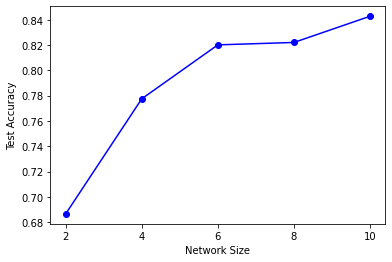

In [ ]:
plt.plot([2,4,6,8,10], accuracies_scratch, 'bo-')
plt.xticks([2,4,6,8,10])
plt.xlabel("Network Size")
plt.ylabel("Test Accuracy")

# plt.plot(np.mean(accuracies_scratch))

## Teacher Size vs Student Accuracy (S=2, T=[4,6,8,10])

In [12]:
from tensorflow.keras.losses import KLDivergence

### T = 4

In [ ]:
# # alpha_vals = [0.1, 0.2, 0.4, 0.8]
# # temp_vals  = [2, 4, 8, 10]

# # for alpha in alpha_vals:
# #   for temp in temp_vals:
student_model_4_2 = createStudentModel(conv_layers=2)
student_model_4_2.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_T4 = Distiller.Distiller(student=student_model_4_2, teacher=student_model_4)
distiller_T4.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.4,
    temperature=4,
)

distiller_T4.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data=(testX, testy), callbacks=[History()])

782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.6932 - student_loss: 0.9131 - distillation_loss: 0.1113 - loss: 1.2604 - val_sparse_categorical_accuracy: 0.7036 - val_loss: 0.6859


In [54]:
# saveModel(student_model_4_2, "TA_KD_Save/student_model_4_2.h5")
student_model_4_2 = loadModel("TA_KD_Save/student_model_4_2.h5")

### T = 6

In [ ]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
  # for temp in temp_vals:
student_model_6_2 = createStudentModel(conv_layers=2)
student_model_6_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_T6 = Distiller.Distiller(student=student_model_6_2, teacher=student_model_6)
distiller_T6.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.1,
    temperature=4,
)

distiller_T6.fit(trainX, trainy, epochs=150, batch_size=64, verbose=0, validation_data = (testX, testy), callbacks=[History()])

In [ ]:
student_model_6_2.evaluate(testX, testy)

313/313 [==============================] - 1s 2ms/step - loss: 0.8380 - sparse_categorical_accuracy: 0.7169


[0.838015615940094, 0.7168999910354614]

In [55]:
# saveModel(student_model_6_2, "TA_KD_Save/student_model_6_2.h5")
student_model_6_2 = loadModel("TA_KD_Save/student_model_6_2.h5")

### T = 8

In [ ]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
student_model_8_2 = createStudentModel(conv_layers=2)
student_model_8_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_T8 = Distiller.Distiller(student=student_model_8_2, teacher=student_model_8)
distiller_T8.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=4,
)

# distiller_T8.fit(trainX, trainy, epochs=50, batch_size=64, verbose=0, callbacks=[History()])
# print("Alpha = ", alpha, ", temp = ", temp, ", accuracy = ", student_model_8_2.evaluate(testX, testy))
distiller_T8.fit(trainX, trainy, epochs=50, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), History()])

Epoch 1/50
782/782 [==============================] - 4s 6ms/step - sparse_categorical_accuracy: 0.4247 - student_loss: 1.7753 - distillation_loss: 0.2937 - loss: 2.3600 - val_sparse_categorical_accuracy: 0.5234 - val_loss: 1.1414
Epoch 2/50
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.5566 - student_loss: 1.2830 - distillation_loss: 0.2108 - loss: 1.7011 - val_sparse_categorical_accuracy: 0.6074 - val_loss: 1.0823
Epoch 3/50
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.5978 - student_loss: 1.1638 - distillation_loss: 0.1852 - loss: 1.5236 - val_sparse_categorical_accuracy: 0.6314 - val_loss: 0.9814
Epoch 4/50
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.6174 - student_loss: 1.1132 - distillation_loss: 0.1742 - loss: 1.4479 - val_sparse_categorical_accuracy: 0.6323 - val_loss: 1.1899
Epoch 5/50
782/782 [==============================] - 4s 5ms/step - sparse_c

In [56]:
# saveModel(student_model_8_2, "TA_KD_Save/student_model_8_2.h5")
student_model_8_2 = loadModel("TA_KD_Save/student_model_8_2.h5")

### T = 10

In [ ]:
student_model_10_2 = createStudentModel(conv_layers=2)
student_model_10_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_T10 = Distiller.Distiller(student=student_model_10_2, teacher=student_model_10)
distiller_T10.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.6,
    temperature=8,
)

distiller_T10.fit(trainX, trainy, epochs=30, batch_size=64, verbose=0, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), History()])

In [ ]:
student_model_10_2.evaluate(testX, testy)

313/313 [==============================] - 1s 2ms/step - loss: 0.9141 - sparse_categorical_accuracy: 0.6990


[0.9141125082969666, 0.6990000009536743]

In [15]:
# saveModel(student_model_10_2, "TA_KD_Save/student_model_10_2.h5")
student_model_10_2 = loadModel("TA_KD_Save/student_model_10_2.h5")

## Plotting and comparing accuracies for different teachers

In [57]:
accuracies_diff_teachers = []

accuracies_diff_teachers.append(student_model_4_2.evaluate(testX, testy)[1])
accuracies_diff_teachers.append(student_model_6_2.evaluate(testX, testy)[1])
accuracies_diff_teachers.append(student_model_8_2.evaluate(testX, testy)[1])
accuracies_diff_teachers.append(student_model_10_2.evaluate(testX, testy)[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.9141 - sparse_categorical_accuracy: 0.6990


In [ ]:
print(accuracies_diff_teachers)

[0.7035999894142151, 0.7168999910354614, 0.7020000219345093, 0.6990000009536743]


Text(0, 0.5, 'Student Test Accuracy')

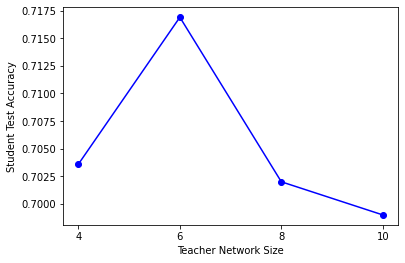

In [ ]:
plt.plot([4,6,8,10], accuracies_diff_teachers, 'bo-')
plt.xticks([4,6,8,10])
plt.xlabel("Teacher Network Size")
plt.ylabel("Student Test Accuracy")

## Student Size vs Student Accuracy (T=10, S=[4,6,8])

### S = 8

In [39]:
# alpha_vals = [0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
# student_model_10_8 = createStudentModel(conv_layers=8)
# student_model_10_8.compile(
#         optimizer=SGD(learning_rate=0.01, momentum=0.9),
#         loss=SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[SparseCategoricalAccuracy()],
#     )

distiller_S8 = Distiller.Distiller(student=student_model_10_8, teacher=student_model_10)
distiller_S8.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=8,
)

# distiller_S8.fit(trainX, trainy, epochs=50, batch_size=64, verbose=0, callbacks=[History()])
# print("Alpha = ", alpha, ", temp = ", temp, ", accuracy = ", student_model_10_8.evaluate(testX, testy))
distiller_S8.fit(trainX, trainy, epochs=1, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), History()])

782/782 [==============================] - 6s 8ms/step - sparse_categorical_accuracy: 0.8487 - student_loss: 0.4405 - distillation_loss: 0.0172 - loss: 0.5725 - val_sparse_categorical_accuracy: 0.8386 - val_loss: 0.3830


In [27]:
# saveModel(student_model_10_8, "TA_KD_Save/student_model_10_8.h5")
student_model_10_8 = loadModel("TA_KD_Save/student_model_10_8.h5")

In [30]:
student_model_10_8.fit(trainX, trainy, epochs = 1, batch_size=64, verbose=1, validation_data = (testX, testy))

782/782 [==============================] - 5s 6ms/step - loss: 0.4461 - sparse_categorical_accuracy: 0.8482 - val_loss: 0.5062 - val_sparse_categorical_accuracy: 0.8337


### S = 6

In [ ]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
student_model_10_6 = createStudentModel(conv_layers=6)
student_model_10_6.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_S6 = Distiller.Distiller(student=student_model_10_6, teacher=student_model_10)
distiller_S6.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.1,
    temperature=2,
)

# distiller_S6.fit(trainX, trainy, epochs=50, batch_size=64, verbose=0, callbacks=[History()])
# print("Alpha = ", alpha, ", temp = ", temp, ", accuracy = ", student_model_10_6.evaluate(testX, testy))
distiller_S6.fit(trainX, trainy, epochs=50, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), History()])

In [10]:
# saveModel(student_model_10_6, "TA_KD_Save/student_model_10_6.h5")
student_model_10_6 = loadModel("TA_KD_Save/student_model_10_6.h5")

### S = 4

In [ ]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
student_model_10_4 = createStudentModel(conv_layers=4)
student_model_10_4.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_S4 = Distiller.Distiller(student=student_model_10_4, teacher=student_model_10)
distiller_S4.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.8,
    temperature=2,
)

# distiller_S4.fit(trainX, trainy, epochs=50, batch_size=64, verbose=0, callbacks=[History()])
# print("Alpha = ", alpha, ", temp = ", temp, ", accuracy = ", student_model_10_4.evaluate(testX, testy))
distiller_S4.fit(trainX, trainy, epochs=50, batch_size=64, verbose=1, validation_data = (testX, testy), callbacks=[EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=10), History()])

In [14]:
# saveModel(student_model_10_4, "TA_KD_Save/student_model_10_4.h5")
student_model_10_4 = loadModel("TA_KD_Save/student_model_10_4.h5")

## Plotting and comparing accuracies for different students

In [44]:
accuracies_diff_students = []

accuracies_diff_students.append(student_model_10_2.evaluate(testX, testy)[1])
accuracies_diff_students.append(student_model_10_4.evaluate(testX, testy)[1])
accuracies_diff_students.append(student_model_10_6.evaluate(testX, testy)[1])
accuracies_diff_students.append(student_model_10_8.evaluate(testX, testy)[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5396 - sparse_categorical_accuracy: 0.8386


In [45]:
print(accuracies_diff_students)

[0.6990000009536743, 0.7950000166893005, 0.8349000215530396, 0.8385999798774719]


In [43]:
print(accuracies_scratch)

[0.6866000294685364, 0.7774999737739563, 0.8256000280380249, 0.8320000171661377, 0.8427000045776367]


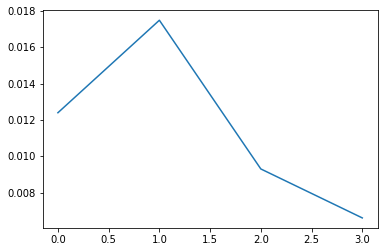

In [50]:
plt.plot(np.array(accuracies_diff_students) - np.array(accuracies_scratch[:-1]))

## Knowledge Distillation with TA

### Choosing the best TA size, S = 2, T = 10, TA = [4,6,8]

### TA = 4

In [65]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
student_model_10_4_2 = createStudentModel(conv_layers=2)
student_model_10_4_2.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_TA_4 = Distiller.Distiller(student=student_model_10_4_2, teacher=student_model_10_4)
distiller_TA_4.compile(
    optimizer=SGD(learning_rate=0.01),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.4,
    temperature=2,
)

distiller_TA_4.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data=(testX, testy))
# print("TA size: 4, alpha = ", alpha, ", temp = ", temp, ", Accuracy: ", distiller_TA_4.evaluate(testX, testy))

782/782 [==============================] - 3s 4ms/step - sparse_categorical_accuracy: 0.7061 - student_loss: 0.8714 - distillation_loss: 0.2626 - loss: 0.9431 - val_sparse_categorical_accuracy: 0.7154 - val_loss: 0.9343


### TA = 6

In [26]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
student_model_10_6_2 = createStudentModel(conv_layers=2)
student_model_10_6_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_TA_6 = Distiller.Distiller(student=student_model_10_6_2, teacher=student_model_10_6)
distiller_TA_6.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=4,
)

# distiller_TA_6.fit(trainX, trainy, epochs=50, batch_size=64, verbose=0)
distiller_TA_6.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data=(testX, testy))
# print("TA size: 6, alpha = ", alpha, ", temp = ", temp, ", Accuracy: ", distiller_TA_6.evaluate(testX, testy))

782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.7188 - student_loss: 0.8408 - distillation_loss: 0.1693 - loss: 1.2146 - val_sparse_categorical_accuracy: 0.7253 - val_loss: 0.8021


### TA = 8

In [28]:
student_model_10_8_2 = createStudentModel(conv_layers=2)
student_model_10_8_2.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_TA_8 = Distiller.Distiller(student=student_model_10_8_2, teacher=student_model_10_8)
distiller_TA_8.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=4,
)

# distiller_TA_8.fit(trainX, trainy, epochs=40, batch_size=64, verbose=1)
distiller_TA_8.fit(trainX, trainy, epochs=100, batch_size=64, verbose=1, validation_data=(testX, testy))
# print("TA size: 8, Accuracy: ", distiller_TA_8.evaluate(testX, testy))

Epoch 1/100
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.4381 - student_loss: 1.7914 - distillation_loss: 0.4135 - loss: 2.7562 - val_sparse_categorical_accuracy: 0.5530 - val_loss: 1.7351
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.5540 - student_loss: 1.3447 - distillation_loss: 0.3199 - loss: 2.0993 - val_sparse_categorical_accuracy: 0.5788 - val_loss: 1.3951
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.5907 - student_loss: 1.2325 - distillation_loss: 0.2864 - loss: 1.9026 - val_sparse_categorical_accuracy: 0.5804 - val_loss: 0.9105
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.6100 - student_loss: 1.1704 - distillation_loss: 0.2684 - loss: 1.7953 - val_sparse_categorical_accuracy: 0.6259 - val_loss: 1.1019
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - spa

## All TA's (10 -> 8 -> 6 -> 4 -> 2)

In [35]:
student_model_10_8_6 = createStudentModel(conv_layers=6)
student_model_10_8_6.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_TA_8 = Distiller.Distiller(student=student_model_10_8_6, teacher=student_model_10_8)
distiller_TA_8.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=4,
)

# distiller_TA_8.fit(trainX, trainy, epochs=40, batch_size=64, verbose=1)
distiller_TA_8.fit(trainX, trainy, epochs=100, batch_size=64, verbose=0, validation_data=(testX, testy))
# print("TA size: 8, Accuracy: ", distiller_TA_8.evaluate(testX, testy))

782/782 [==============================] - 6s 7ms/step - sparse_categorical_accuracy: 0.8770 - student_loss: 0.3526 - distillation_loss: 0.0699 - loss: 0.5057 - val_sparse_categorical_accuracy: 0.8434 - val_loss: 0.5465


In [60]:
student_model_10_8_6_4 = createStudentModel(conv_layers=4)
student_model_10_8_6_4.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

distiller_TA_8_6 = Distiller.Distiller(student=student_model_10_8_6_4, teacher=student_model_10_8_6)
distiller_TA_8_6.compile(
    optimizer=Adam(),
    metrics=[SparseCategoricalAccuracy()],
    student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=KLDivergence(),
    alpha=0.2,
    temperature=4,
)

# distiller_TA_8.fit(trainX, trainy, epochs=40, batch_size=64, verbose=1)
distiller_TA_8_6.fit(trainX, trainy, epochs=100, batch_size=64, verbose=0, validation_data=(testX, testy))
# print("TA size: 8, Accuracy: ", distiller_TA_8.evaluate(testX, testy))

782/782 [==============================] - 5s 6ms/step - sparse_categorical_accuracy: 0.8545 - student_loss: 0.4047 - distillation_loss: 0.0877 - loss: 0.6044 - val_sparse_categorical_accuracy: 0.8028 - val_loss: 0.8281


In [61]:
saveModel(student_model_10_8_6_4, "TA_KD_Save/student_model_10_8_6_4.h5")

In [81]:
# alpha_vals = [0.1, 0.2, 0.4, 0.8]
# temp_vals  = [2, 4, 8, 10]

# for alpha in alpha_vals:
#   for temp in temp_vals:
# student_model_10_8_6_4_2 = createStudentModel(conv_layers=2)
# student_model_10_8_6_4_2.compile(
#         optimizer=Adam(),
#         loss=SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[SparseCategoricalAccuracy()],
#     )

# distiller_TA_8_6_4 = Distiller.Distiller(student=student_model_10_8_6_4_2, teacher=student_model_10_8_6_4)
# distiller_TA_8_6_4.compile(
#     optimizer=Adam(),
#     metrics=[SparseCategoricalAccuracy()],
#     student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
#     distillation_loss_fn=KLDivergence(),
#     alpha=0.2,
#     temperature=10,
# )

# distiller_TA_8_6_4.fit(trainX, trainy, epochs=40, batch_size=64, verbose=0)
distiller_TA_8_6_4.fit(trainX, trainy, epochs=5, batch_size=64, verbose=1, validation_data=(testX, testy))
# print("TA size: 8->6->4, alpha = ", alpha, ", temp = ", temp, ", Accuracy: ", distiller_TA_8_6_4.evaluate(testX, testy))

Epoch 1/5
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.7138 - student_loss: 0.8308 - distillation_loss: 0.0228 - loss: 1.1214 - val_sparse_categorical_accuracy: 0.7309 - val_loss: 0.8047
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.7131 - student_loss: 0.8320 - distillation_loss: 0.0228 - loss: 1.1215 - val_sparse_categorical_accuracy: 0.7043 - val_loss: 0.7159
Epoch 3/5
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.7145 - student_loss: 0.8316 - distillation_loss: 0.0228 - loss: 1.1209 - val_sparse_categorical_accuracy: 0.7249 - val_loss: 0.8080
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - sparse_categorical_accuracy: 0.7138 - student_loss: 0.8291 - distillation_loss: 0.0228 - loss: 1.1197 - val_sparse_categorical_accuracy: 0.7145 - val_loss: 0.7716
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - sparse_catego

In [ ]:
# with open('TA_KD_Save/accuracies.npy', 'wb') as f:
#   np.save(f, accuracies_scratch)
#   np.save(f, accuracies_diff_teachers)
#   np.save(f, accuracies_diff_students)

### Results till now for No KD, Baseline KD, TA KD on CIFAR - 10

| No KD | Baseline KD | TA KD |
| :- | -: | :-: |
| 64.6% | 70.5% | 70.6%

### Plotting data found till now

In [ ]:
# plt.plot([2,4,6,8,10], accuracies_scratch, 'bo-')
# plt.xticks([2,4,6,8,10])
# plt.xlabel("Network Size")
# plt.ylabel("Test Accuracy")

In [ ]:
# plt.bar([8, 6, 4, 2], accuracies_diff_students, color='g', width=0.5)
# plt.xticks([8, 6, 4, 2])
# plt.xlabel("Student Size")
# plt.ylabel("Accuracy Gain")

In [ ]:
# w = 0.3

# X = np.arange(len(training_data))
# fig, ax = plt.subplots(figsize=(12, 8))

# bar = ax.bar(X - 0.125, np.array(res)*100, color = 'r', width = 0.25)
# bar_KD = ax.bar(X + 0.125, np.array(res_KD)*100, color = 'g', width = 0.25)

# def autolabel(rects, xpos='center'):
#     """
#     Attach a text label above each bar in *rects*, displaying its height.

#     *xpos* indicates which side to place the text w.r.t. the center of
#     the bar. It can be one of the following {'center', 'right', 'left'}.
#     """

#     ha = {'center': 'center', 'right': 'left', 'left': 'right'}
#     offset = {'center': 0, 'right': 1, 'left': -1}

#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{:.1f}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(offset[xpos]*3, 3),  # use 3 points offset
#                     textcoords="offset points",  # in both directions
#                     ha=ha[xpos], va='bottom')
        
# autolabel(bar, "left")
# autolabel(bar_KD, "right")

# ax.set_ylabel('Accuracy')
# ax.set_xlabel('Fraction of training data')
# ax.set_xticks(range(len(training_data)))
# ax.set_xticklabels(training_data)

# ax.legend((bar[0], bar_KD[0]), ('without KD', 'with KD'))
# plt.show()